# Реализация алгоритма Вигдерзона

Напомним, что алгоритм работает так:
1) Пока есть вершины с $deg(v) \geq \sqrt{n}$ тратим на нее и всех ее соседей 3 цвета и удаляем их.
2) Оставшиеся вершины красим в $deg(G')+ 1$ цвет.

Для работы с графами будем использовать библиотеку NetworkX.

In [196]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from random import randint

## Сам алгоритм

In [237]:
def color_graph(G: nx.Graph) -> (list, int):
    '''
    Colors a 3-colorable graph with O(sqrt(n)) colors. Returns coloring and number of colors used
    '''
    n = len(G.nodes)
    colors = [None] * n
    next_free_color = 1
    # Step 1
    while True:
        v = -1
        for i in range(n):
            if colors[i] is None and G.degree[i] >= round(sqrt(n)):
                v = i
                break
        if v == -1:
            break

        colors[v] = next_free_color
        a = next_free_color + 1
        b = next_free_color + 2
        next_free_color += 3
        for i in [x for x in G.neighbors(v)]:
            current_neighbours = [x for x in G.neighbors(i)]
            occupied_colors = []
            for t in current_neighbours:
                occupied_colors.append(colors[t])

            # Only 2 colours are used here
            if a in occupied_colors:
                colors[i] = b
            else:
                assert a not in occupied_colors
                colors[i] = a

    # Step 2
    uncolored = []
    start_color = next_free_color
    for i in range(n):
        if colors[i] is None:
            uncolored.append(i)
    for i in uncolored:
        current_neighbours = [x for x in G.neighbors(i)]
        occupied_colors = []
        for t in current_neighbours:
            occupied_colors.append(colors[t])
        for color in range(start_color, n + 1):
            if color not in occupied_colors:
                colors[i] = color
                break

    return colors, max(colors)


## Генерация 3-раскрашиваемого графа

Будем случайным образом выбирать еще не проведенное ребро, если оно не образует 4-клики (а значит не нарушает 3-раскрашиваемость), то добавляем его в граф.

In [238]:
def generate(n: int, m: int, part: int, edges = False):
    '''
    Tries to generate a graph with n vertices and m edges, at most part of vertices have
    degree less than sqrt(n). If generation fails, returns None.
    '''
    free_edges = []
    deg = [0] * n
    for i in range(n):
        for j in range(i + 1, n):
            free_edges.append([i, j])

    G = nx.Graph()
    G.add_nodes_from(np.arange(n))
    while m > 0:
        a = -1
        b = -1
        found = False
        for _ in range(n):
            if len(free_edges) == 0:
                return None
            x = randint(0, len(free_edges) - 1)
            a = free_edges[x][0]
            b = free_edges[x][1]
            if not edges:
                if part <= 1 and (deg[a] + 1 > round(sqrt(n)) and deg[b] + 1 > round(sqrt(n))):
                    free_edges.remove([a, b])
                    continue
                if part <= 0 and (deg[a] + 1 > round(sqrt(n)) or deg[b] + 1 > round(sqrt(n))):
                    free_edges.remove([a, b])
                    continue
            assert not G.has_edge(a, b)

            flag = True
            for i in range(n):
                if not flag:
                    break
                if i == a or i == b:
                    continue
                for j in range(i + 1, n):
                    if not flag:
                        break
                    if j == a or j == b:
                        continue
                    if not G.has_edge(i, j):
                        continue

                    if G.has_edge(a, i) and G.has_edge(a, j) and G.has_edge(b, i) and G.has_edge(b, j):
                        flag = False
                        break

            if flag:
                found = True
                break

        if not found:
            return None

        free_edges.remove([a, b])
        G.add_edge(a, b)
        deg[a] += 1
        deg[b] += 1
        if not edges:
            if deg[a] > round(sqrt(n)):
                part -= 1
            if deg[b] > round(sqrt(n)):
                part -= 1
        m -= 1

    return G

def is_3colorable(G: nx.Graph) -> bool:
    '''
    If graph is 3-colorable returns True, otherwise returns False.
    '''
    n = len(G.nodes)
    for i in range(n):
        for j in range(i + 1, n):
            for k in range(j + 1, n):
                for l in range(k + 1, n):
                    if G.has_edge(i, j) and G.has_edge(i, k) and G.has_edge(i, l) and G.has_edge(j, k) and G.has_edge(j, l) and G.has_edge(k, l):
                        return False
    return True

def generate_3colorable_graph(n: int, edges = False) -> nx.Graph:
    '''
    Returns 3-colorable nx.Graph with n vertices.
    If edges is True, graph has a lot of vertices
    '''
    part = randint(2 * round(sqrt(n)), n)
    if edges:
        part = n
    m = randint(0, part * n + (n - part) * round(sqrt(n)))
    while True:
        G = generate(n, m, part, edges)
        if G is None:
            m = m * 3 // 4
        else:
            assert is_3colorable(G)
            return G


Функция `generate_3colorable_graph` возврашает 3-раскрашиваемый граф размера $n$. Второй параметр определяет, сколько в графе будем ребер.

## Анализ алгоритма

Для всех $n$ из отрезка $[10, 100]$ с шагом $3$ посчитаем число затраченных цветов. Для каждого $n$ запустим несколько раз генерацию и раскраску нового графа.

In [243]:
n = np.arange(10, 100, 3)
c = []

for size in n:
    print(f'Counting colors for {size}-vertex Graph...')
    mean_colors = 0
    for _ in range(15):
        G = generate_3colorable_graph(size, False)
        coloring, colors = color_graph(G)
        mean_colors += colors
    for _ in range(15):
        G = generate_3colorable_graph(size, True)
        coloring, colors = color_graph(G)
        mean_colors += colors
    mean_colors /= 30
    print(f'- Done. On average {round(mean_colors, 1)} colors are used.')
    c.append(mean_colors)

Counting colors for 10-vertex Graph...
- Done. On average 8.7 colors are used.
Counting colors for 13-vertex Graph...
- Done. On average 7.9 colors are used.
Counting colors for 16-vertex Graph...
- Done. On average 12.0 colors are used.
Counting colors for 19-vertex Graph...
- Done. On average 12.6 colors are used.
Counting colors for 22-vertex Graph...
- Done. On average 13.3 colors are used.
Counting colors for 25-vertex Graph...
- Done. On average 15.9 colors are used.
Counting colors for 28-vertex Graph...
- Done. On average 16.4 colors are used.
Counting colors for 31-vertex Graph...
- Done. On average 17.2 colors are used.
Counting colors for 34-vertex Graph...
- Done. On average 17.8 colors are used.
Counting colors for 37-vertex Graph...
- Done. On average 20.8 colors are used.
Counting colors for 40-vertex Graph...
- Done. On average 21.0 colors are used.
Counting colors for 43-vertex Graph...
- Done. On average 20.6 colors are used.
Counting colors for 46-vertex Graph...
- D

Теперь изобразим полученные данные.

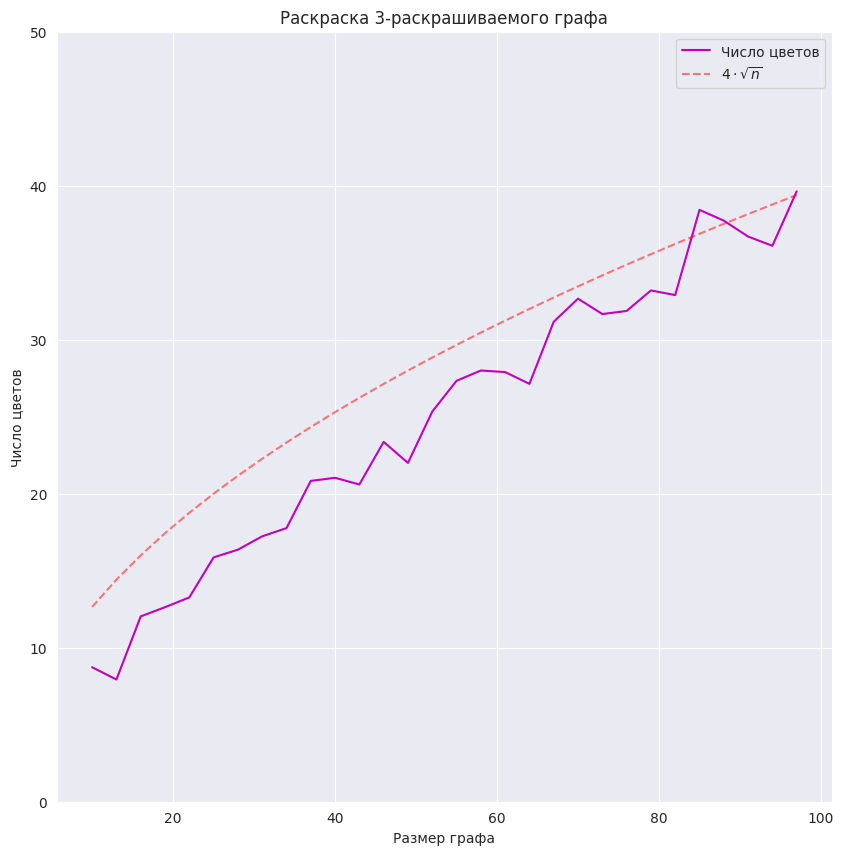

In [249]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(10, 10))
    plt.plot(n, c, color='m', label='Число цветов')
    plt.plot(n, 4 * np.sqrt(n), color='r', linestyle='--', alpha=0.5, label='$4 \cdot \sqrt{n}$')
    plt.title('Раскраска 3-раскрашиваемого графа')
    plt.xlabel('Размер графа')
    plt.ylabel('Число цветов')
    plt.ylim((0, 50))
    plt.legend()

Как мы видим по графику, теоретическая оценка числа затраченных цветов подтвердилась на практике.

...